# Consensus WBF

In [1]:
import os

from utils.metrics import create_plots
from utils.consensus_WBF import calculate_consensus_focus, ensemble_reweight, weighted_boxes_fusion, convert_darknet, toDarknet

## Directory structure

We declare a base path to store the inferences on the target domain from every source network. They all must have the same number of text files. The directory structure should be as follows:

```
base_path
│       
└───labels
│   │   model1
│       │   inference_darknet_format_1.txt
│       │   inference_darknet_format_2.txt
|       |   inference_darknet_format_3.txt
│       │   ...
│   │   model2
│       │   inference_darknet_format_1.txt
│       │   inference_darknet_format_2.txt
|       |   inference_darknet_format_3.txt
│       │   ...
│   │   model3
│       │   inference_darknet_format_1.txt
│       │   inference_darknet_format_2.txt
|       |   inference_darknet_format_3.txt
│       │   ...
|   |   modeln
|       |   ...
```

In [2]:
iou_thr = 0.50
skip_box_thr=3*[0.0001]
#You can customize it accordingly. Example:
#skip_box_thr[0]=0.84 #pedestrian
#skip_box_thr[1]=0.95 #motorized-vehicle
#skip_box_thr[2]=0.84 #non-motorized-vehicle
initial_weights = [1,1,1,1] ##Initial weights
m_folder="inputs/labels/"
conf_type='max' #Also try: avg, box_and_model_avg, absent_model_aware_avg

## Consensus focus for object detection

The consensus quality for object detection is the sum of the product between the number of models supporting a fused bounding box in a source dataset subset $S' \subseteq S$. Here, we denote $S = \left\{ D^{(i)} \right\}^{I}_{i=1}$ as a set of source datasets and $Q\left( S' \right)$ is the consensus quality of a subset of $S$:

$$
Q(S')=\sum_{x^{T}_{j} \epsilon X^{(T)}}\sum_{b_{j} \epsilon B_{j}}n_{b_j}(S')p_{b_j}(S')
$$

The consensus focus $CF\left( D^{(i)} \right)$ quantifies the contribution of each source domain through the surveys based on measuring the total consensus quality of all combinations between the elements of $S$. In other words, the CF designates the marginal contribution of the single source domain $D^{(i)}$ to the consensus quality of all source domains $S$.

$$
CF\left( D^{(i)}\right)=Q\left(S \right)-Q\left( S\smallsetminus D^{(i)} \right)
$$

In [3]:
consensus_focus_dict=calculate_consensus_focus(m_folder=m_folder, skip_box_thr=skip_box_thr, initial_weights=initial_weights, iou_thr=iou_thr,conf_type=conf_type)
print(consensus_focus_dict)

['inputs/labels/', 'inputs/labels/13-00_CLEAR_SKY', 'inputs/labels/18-00_CLEAR_SKY', 'inputs/labels/FCAV', 'inputs/labels/VKITTI']
{1: 2548.8662991873357, 2: 2511.3005490795213, 3: 2086.6749981423973, 4: 386.18139358317546}


### **Case I**. Ensembling of multiple models.
It indicates the relevance of each model according to their consensus focus metrics.

$$
\alpha_{i}^{CF}=\frac{M^{(i)}CF\left(D^{(i)} \right)}{\sum_{i=1}^{I}M^{(i)}CF\left(D^{(i)} \right)}
$$

And their sum equals 1

$$
\sum_{i=0}^{I}\alpha_{i}^{CF}=1
$$

In [4]:
M_i=[8460, 8388, 8000, 3200] #each entry represents the number of samples per source dataset no matter the data imbalance. In this example, we trained our models using such numbers for APOLLO 13-00 CLEAR SKY, APOLLO 18-00 CLEAR SKY, FCAV, and VKITTY2
aicf=ensemble_reweight(cfd=consensus_focus_dict,M_i=M_i)
aicf

[0.3560822724120435,
 0.3478484304079407,
 0.27566252771091654,
 0.020406769469099244]

In [5]:
sum(aicf)

1.0

We suggest reweighting each term in the WBF through the following equation:
$$
\text{Weight}_i=\frac{\alpha_{i}^{CF}}{\text{min} \left( \alpha^{CF} \right)}
$$
Where 

$$
\alpha^{CF}=\left\{ \alpha_{0}^{CF}, \alpha_{i}^{CF},..,\alpha_{I}^{CF} \right\}
$$

In [6]:
weights_i = list(aicf/min(aicf))
weights_i

[17.44922306057496, 17.04573724590102, 13.508386426785282, 1.0]

Finally, we can recalculate the WBF using $\text{Weight}_i$ as follows

In [7]:
data_files = [x[0] for x in os.walk(m_folder)] #folder list
m1_folder = data_files[1:][0]+'/'
data_files1 = [x[2] for x in os.walk(m1_folder)][0] #list of txt files, one per image
WBF_new, WBF_ones = [], []
weights_old=[1,1,1,1]
weights_i
for i in range(len(data_files1)):
    boxes_list = []
    scores_list = []
    labels_list = []
    for j in range(1,len(data_files)):
        tmp=open(data_files[j]+'/'+data_files1[i]).read().split('\n')
        box_list, score_list, lbl_list = convert_darknet(tmp)
        boxes_list.append(box_list)
        scores_list.append(score_list)
        labels_list.append(lbl_list)
    bxs_o, scr_o, lbl_o, _ = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights_old, iou_thr=iou_thr, skip_box_thr=skip_box_thr,conf_type=conf_type,allows_overflow=False)
    bxs, scr, lbl, _ = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights_i, iou_thr=iou_thr, skip_box_thr=skip_box_thr,conf_type=conf_type,allows_overflow=False)
    WBF_new.append(toDarknet(bxs,lbl,scr)) # darknet format
    WBF_ones.append(toDarknet(bxs_o,lbl_o,scr_o)) #setting the initial weights for WBF as ones

### Save the new boxes in a txt file

In [ ]:
!rm -rf output/labels

In [8]:
from pathlib import Path
newlbl_dir='output/labels'
if not os.path.exists(newlbl_dir):
    os.makedirs(newlbl_dir)
labels_path = Path(f"{newlbl_dir}")#labels path
for i in range(len(WBF_new)):
    with (labels_path/data_files1[i]).open(mode="w") as label_file:
        if WBF_new[i] == None:
            label_file.write("\n")
        else:
            for j in range(len(WBF_new[i])):
                label_file.write(
                    f"{WBF_new[i][j][0]} {WBF_new[i][j][1]} {WBF_new[i][j][2]} {WBF_new[i][j][3]} {WBF_new[i][j][4]} {WBF_new[i][j][5]}\n"
                )

### (Optional) Generate confusion matrix, F1 curve, PR curve and other metrics

You need to provide the paths to access the ground-truth images, labels and the predictions calculated a few lines above.

In [9]:
import os

from utils.metrics import create_plots
from utils.consensus_WBF import calculate_consensus_focus, ensemble_reweight, weighted_boxes_fusion, convert_darknet, toDarknet

[array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), array([0.95434804, 0.91297001, 0.84911771, ..., 0.55479099, 0.40392493,
       0.30540764]), array([2., 0., 1., ..., 1., 1., 1.]), array([1., 2., 1., ..., 2., 1., 1.])] 4
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95
                 all         889        6123       0.775       0.432        0.43       0.313
          pedestrian         889        1333       0.843       0.351       0.353       0.238
   motorized-vehicle         889        4556       0.831       0.557       0.554       0.418
non-motorized-vehicle         889         234       0.651       0.389       0.384       0.282


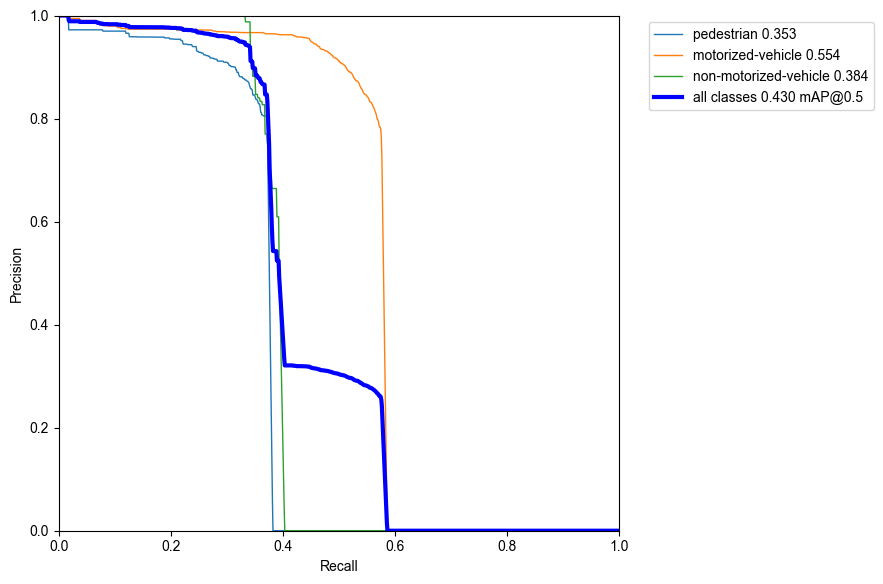

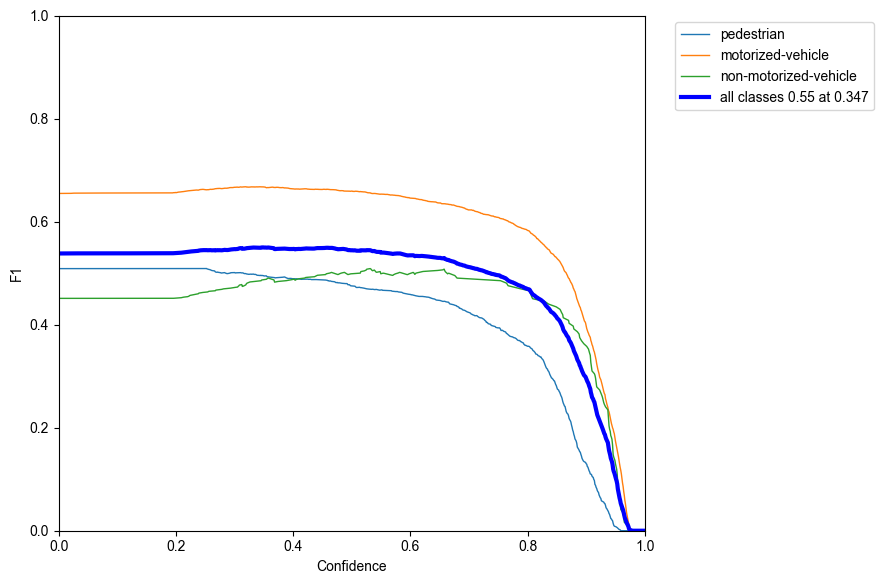

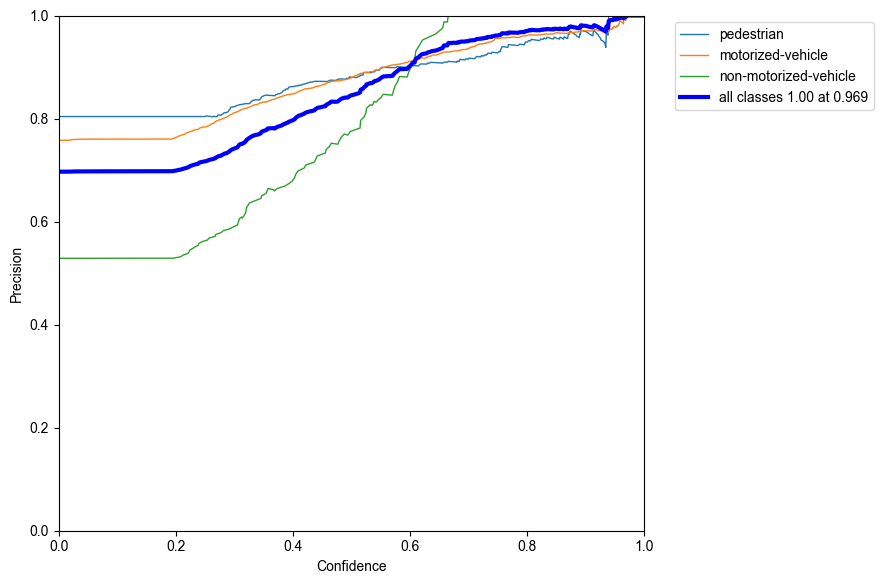

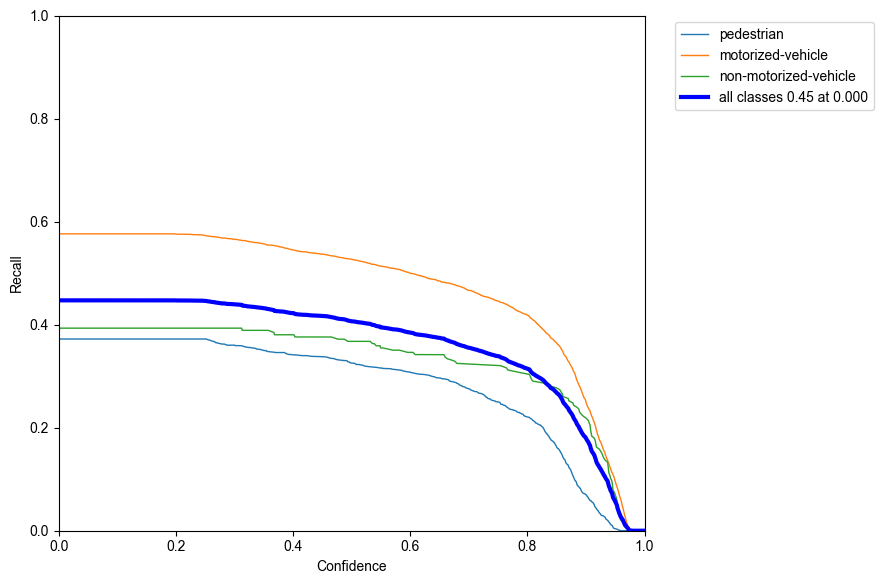

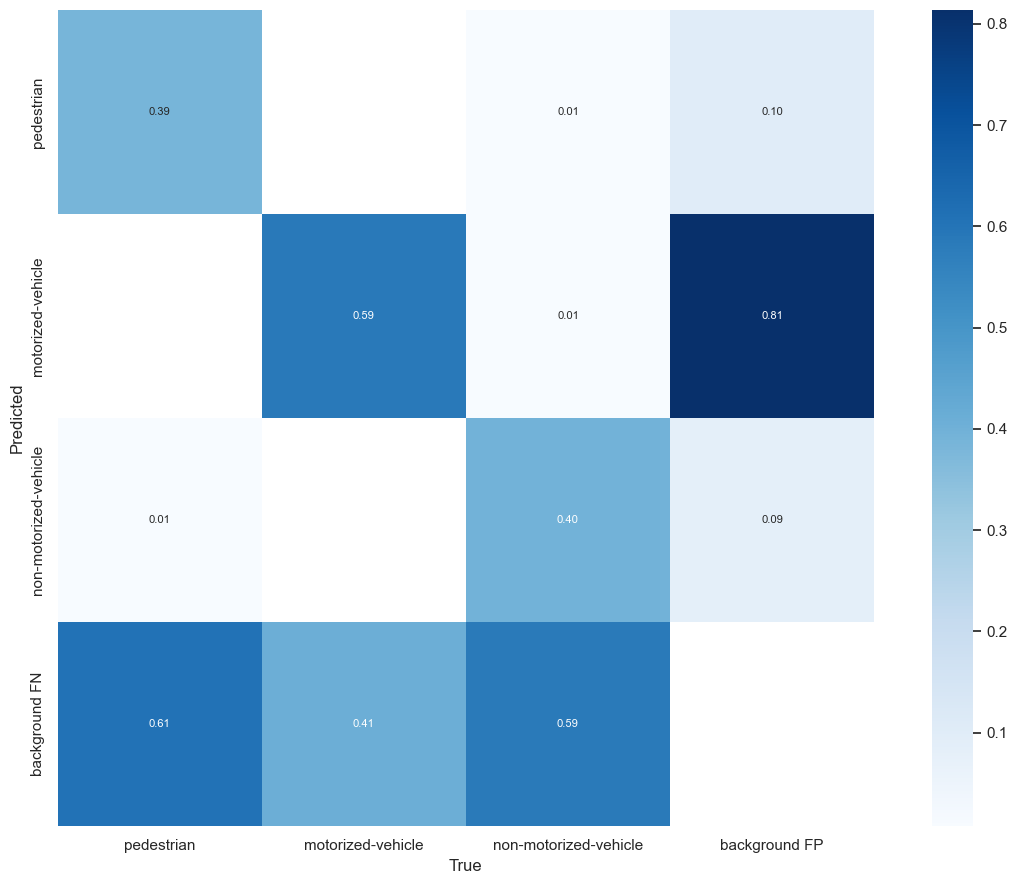

In [10]:
gt_lbl='17-00_CLEAR_SKY_yolov8/labels/val/' #groundtruth target dataset
gt_img='17-00_CLEAR_SKY_yolov8/images/val/'
wbf_lbl='output/labels/'
categories=['pedestrian', 'motorized-vehicle', 'non-motorized-vehicle']
ap_class, seen, nt, p, r, ap50, ap = create_plots(gt_lbl,gt_img,wbf_lbl,categories)